# LEAPS Data Exploration

The LEAPS data is a collection of complete programs in the LEAPS Karel DSL for controlling an agent in the Karel environment.
My goal is to explore how the programs in the dataset perform on the Karel tasks to serve as a baseline dataset. This
will be compared against the dataset being generated using a random policy for the Karel tasks.

## Imports

In [8]:
import tables as tb

## Read data

In [9]:
leaps = tb.File('leaps/data/data-001.hdf5', 'r')

In [33]:
# Explore hdf5 file layout and data
count = 0

for idx, node in enumerate(leaps.walk_nodes()):
    count += 1

print(count)

/home/akrish13/miniconda3/envs/decision-transformer-microrts/lib/python3.11/site-packages/tables/group.py:1160: UserWarning: problems loading leaf ``/data_info/dsl_type``::

  variable length strings are not supported yet

The leaf will become an ``UnImplemented`` node.
  warnings.warn(


300013


In [4]:
data_info = leaps.get_node('/data_info')
print(data_info._f_list_nodes())

[/data_info/dsl_type (UnImplemented()) ''
  NOTE: <The UnImplemented object represents a PyTables unimplemented
         dataset present in the 'leaps/data/data-001.hdf5' HDF5 file.  If you want to see this
         kind of HDF5 dataset implemented in PyTables, please contact the
         developers.>
, /data_info/max_demo_length (Array()) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None, /data_info/max_program_length (Array()) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None, /data_info/min_demo_length (Array()) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None, /data_info/min_program_length (Array()) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None, /data_info/num_action_tokens (Array()) ''
  atom := I

/home/akrish13/miniconda3/envs/decision-transformer-microrts/lib/python3.11/site-packages/tables/group.py:1160: UserWarning: problems loading leaf ``/data_info/dsl_type``::

  variable length strings are not supported yet

The leaf will become an ``UnImplemented`` node.
  warnings.warn(


In [5]:
min_program_length = leaps.get_node('/data_info/min_program_length').read()
print(min_program_length)

7


In [10]:
max_program_length = leaps.get_node('/data_info/max_program_length').read()
print(max_program_length)

50


In [7]:
p1 = leaps.get_node('/no_0_prog_len_19_max_s_h_len_5')
print(p1._f_list_nodes())

[/no_0_prog_len_19_max_s_h_len_5/a_h (Array(10, 4)) ''
  atom := Int8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None, /no_0_prog_len_19_max_s_h_len_5/a_h_len (Array(10,)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None, /no_0_prog_len_19_max_s_h_len_5/program (Array(19,)) ''
  atom := Int8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None, /no_0_prog_len_19_max_s_h_len_5/s_h (Array(10, 5, 8, 8, 16)) ''
  atom := EnumAtom(enum=Enum({'FALSE': 0, 'TRUE': 1}), dflt='FALSE', base=Int8Atom(shape=(), dflt=0), shape=())
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None, /no_0_prog_len_19_max_s_h_len_5/s_h_len (Array(10,)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None]


In [14]:
p1_prog = leaps.get_node('/no_0_prog_len_19_max_s_h_len_5')
prog = p1_prog._f_get_child('program').read()
print(prog)

[ 0  1  2  6  4  6  4 49 32 41 33 47 31 27  9  4 10 48  3]


## Produce dataset

In [24]:
import sys

sys.path.insert(0, 'leaps')

from leaps.prl_gym.exec_env import ExecEnv2
from leaps.pretrain.get_karel_config import get_karel_task_config

/home/akrish13/miniconda3/envs/decision-transformer-microrts/lib/python3.11/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment CartPoleDiscrete-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [44]:
programs = []
tasks = ['cleanHouse', 'harvester', 'fourCorners', 'randomMaze', 'stairClimber', 'topOff']
rewards = { task: [] for task in tasks }

for idx, node in enumerate(leaps.walk_nodes()):
    if 'program' in node:
        prog_node = node
        program_seq = prog_node._f_get_child('program').read()
        for idx, task in enumerate(tasks):
            karel_env = ExecEnv2(get_karel_task_config(task))
            if idx == 0:
                program_str = karel_env.dsl.intseq2str(program_seq)
                programs.append(program_str)
            reward, _ = karel_env.reward(program_seq)
            rewards[task].append(reward)

In [41]:
import pandas as pd

df = pd.DataFrame({
    'programs': programs,
    'cleanHouse_reward': rewards['cleanHouse'],
    'harvester_reward': rewards['harvester'],
    'fourCorners_reward': rewards['fourCorners'],
    'randomMaze_reward': rewards['randomMaze'],
    'stairClimber_reward': rewards['stairClimber'],
    'topOff_reward': rewards['topOff'],
})
print(df.describe())
df.to_csv('leaps_data.csv', index=False)

       cleanHouse_reward  harvester_reward  fourCorners_reward  \
count        50000.00000      50000.000000        50000.000000   
mean             0.10005          0.086496            0.102710   
std              0.00215          0.083187            0.026176   
min              0.10000         -1.261111            0.100000   
25%              0.10000          0.100000            0.100000   
50%              0.10000          0.100000            0.100000   
75%              0.10000          0.100000            0.100000   
max              0.26000          0.655556            1.100000   

       randomMaze_reward  stairClimber_reward  topOff_reward  
count       50000.000000         50000.000000   50000.000000  
mean            0.180068             0.102520       0.223384  
std             0.098164             0.033444       0.113934  
min             0.100000             0.100000       0.100000  
25%             0.100000             0.100000       0.100000  
50%             0.200000   

In [1]:
import pandas as pd

df = pd.read_csv('leaps_data.csv')
df.describe()

,Unnamed: 0,cleanHouse_reward,harvester_reward,fourCorners_reward,randomMaze_reward,stairClimber_reward,topOff_reward,prog_len
count,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,0.10005,0.086496,0.102710,0.180068,0.102520,0.223384,19.301080
std,14433.901067,0.00215,0.083187,0.026176,0.098164,0.033444,0.113934,5.961726
min,0.000000,0.10000,-1.261111,0.100000,0.100000,0.100000,0.100000,7.000000
25%,12499.750000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,15.000000
50%,24999.500000,0.10000,0.100000,0.100000,0.200000,0.100000,0.190909,19.000000
75%,37499.250000,0.10000,0.100000,0.100000,0.200000,0.100000,0.300000,23.000000
max,49999.000000,0.26000,0.655556,1.100000,1.100000,1.100000,1.100000,50.000000


In [50]:
def prog_len(prog):
    env = ExecEnv2(config=get_karel_task_config('harvester'))
    prog_seq = env.dsl.str2intseq(prog)
    return len(prog_seq)

df['prog_len'] = df['programs'].apply(lambda prog: prog_len(prog))
df.describe()

,cleanHouse_reward,harvester_reward,fourCorners_reward,randomMaze_reward,stairClimber_reward,topOff_reward,prog_len
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.10005,0.086496,0.102710,0.180068,0.102520,0.223384,19.301080
std,0.00215,0.083187,0.026176,0.098164,0.033444,0.113934,5.961726
min,0.10000,-1.261111,0.100000,0.100000,0.100000,0.100000,7.000000
25%,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,15.000000
50%,0.10000,0.100000,0.100000,0.200000,0.100000,0.190909,19.000000
75%,0.10000,0.100000,0.100000,0.200000,0.100000,0.300000,23.000000
max,0.26000,0.655556,1.100000,1.100000,1.100000,1.100000,50.000000


In [55]:
def new_harvester(prog):
    env = ExecEnv2(config=get_karel_task_config('harvester'))
    reward, _ = env.reward(prog, is_program_str=True)
    return reward

df['harvester_reward'] = df['programs'].apply(new_harvester)
df.describe()

KeyboardInterrupt: 

In [ ]:
df.to_csv('leaps_data.csv')

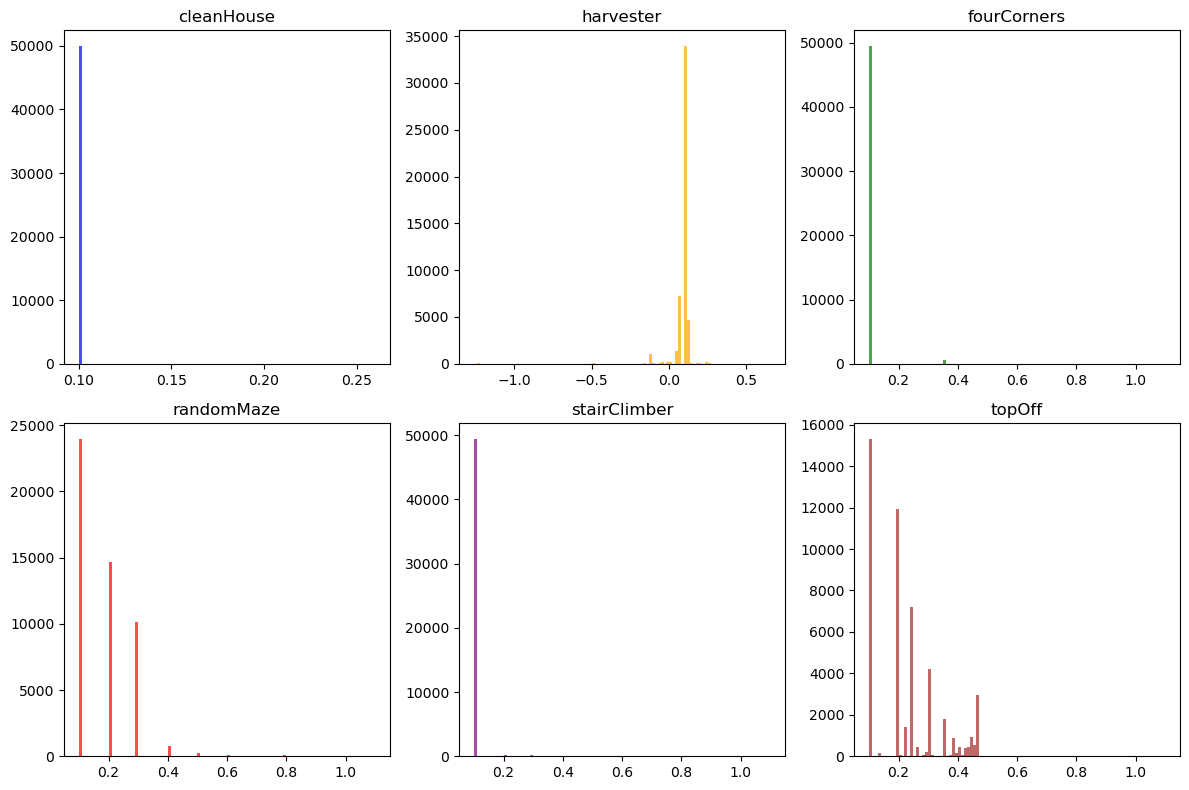

In [2]:
import matplotlib.pyplot as plt

num_bins = 100

# Create a figure and arrange subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Plot the distributions in each subplot
axes[0, 0].hist(df.cleanHouse_reward, bins=num_bins, color='blue', alpha=0.7)
axes[0, 0].set_title('cleanHouse')

axes[0, 1].hist(df.harvester_reward, bins=num_bins, color='orange', alpha=0.7)
axes[0, 1].set_title('harvester')

axes[0, 2].hist(df.fourCorners_reward, bins=num_bins, color='green', alpha=0.7)
axes[0, 2].set_title('fourCorners')

axes[1, 0].hist(df.randomMaze_reward, bins=num_bins, color='red', alpha=0.7)
axes[1, 0].set_title('randomMaze')

axes[1, 1].hist(df.stairClimber_reward, bins=num_bins, color='purple', alpha=0.7)
axes[1, 1].set_title('stairClimber')

axes[1, 2].hist(df.topOff_reward, bins=num_bins, color='brown', alpha=0.7)
axes[1, 2].set_title('topOff')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
anomalous = df[df.filter(like='_reward').apply(lambda col: (col < 0) | (col > 1)).any(axis=1)]
print(anomalous)

anomalous.to_csv('anomalous.csv')

                                                programs  cleanHouse_reward  \
48     DEF run m( WHILE c( frontIsClear c) w( move mo...                0.1   
99     DEF run m( REPEAT R=8 r( turnLeft putMarker r)...                0.1   
100    DEF run m( WHILE c( not c( rightIsClear c) c) ...                0.1   
142    DEF run m( putMarker move IFELSE c( frontIsCle...                0.1   
149    DEF run m( IF c( frontIsClear c) i( move move ...                0.1   
...                                                  ...                ...   
49844  DEF run m( WHILE c( frontIsClear c) w( turnLef...                0.1   
49874  DEF run m( WHILE c( markersPresent c) w( putMa...                0.1   
49924  DEF run m( putMarker move move move WHILE c( l...                0.1   
49969  DEF run m( move REPEAT R=5 r( putMarker r) mov...                0.1   
49974  DEF run m( move move IF c( noMarkersPresent c)...                0.1   

       harvester_reward  fourCorners_reward  random

In [23]:
tasks = ['cleanHouse', 'harvester', 'fourCorners', 'randomMaze', 'stairClimber', 'topOff']
df[df['harvester_reward'] == df['harvester_reward'].min()].programs.values[0]

'DEF run m( putMarker move turnLeft WHILE c( rightIsClear c) w( putMarker move w) m)'

In [54]:
max_len = df[df['prog_len'] == df['prog_len'].max()].programs.values[0]
print('\n'.join([f'{idx}, {token}' for idx, token in enumerate(max_len.split())]))

0, DEF
1, run
2, m(
3, IFELSE
4, c(
5, rightIsClear
6, c)
7, i(
8, IF
9, c(
10, not
11, c(
12, markersPresent
13, c)
14, c)
15, i(
16, turnRight
17, i)
18, WHILE
19, c(
20, frontIsClear
21, c)
22, w(
23, turnRight
24, w)
25, i)
26, ELSE
27, e(
28, IF
29, c(
30, markersPresent
31, c)
32, i(
33, IFELSE
34, c(
35, not
36, c(
37, frontIsClear
38, c)
39, c)
40, i(
41, move
42, i)
43, ELSE
44, e(
45, putMarker
46, e)
47, i)
48, e)
49, m)


In [4]:
from collections import Counter
print(Counter(df['fourCorners_reward']))

Counter({0.1: 49461, 0.35: 538, 1.1: 1})
